In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_baseline_moving_avg(file_list, window_size, theta=0.5):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep=',', skiprows = 0, header= 1)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-theta*smoothed_std, smoothed_avg+theta*smoothed_std
    
def find_drpo_moving_avg(file_list, window_size, theta = 0.5):  
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', header= None)
            y_val = df[1]
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', header= None)
            data[i,:] = df[1].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-theta*smoothed_std, smoothed_avg+theta*smoothed_std

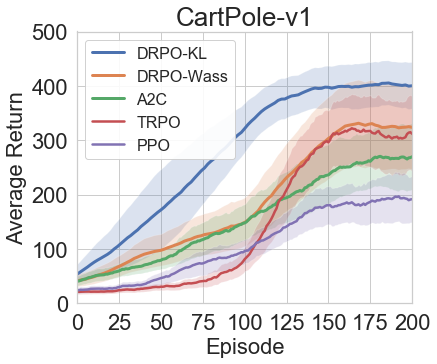

In [2]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

a2c_file_list = ['./log_files/a2c/CartPole-v1-1583988257.742302.csv', './log_files/a2c/CartPole-v1-1581924218.222175.csv',
                './log_files/a2c/CartPole-v1-1583951983.017687.csv','./log_files/a2c/CartPole-v1-1583953260.6407459.csv',
                './log_files/a2c/CartPole-v1-1583953298.755656.csv']
kl_file_list = ['./log_files/dr_trpo_kl/CartPole-v1-1581924483.4587069.csv', './log_files/dr_trpo_kl/CartPole-v1-1583890398.574406.csv',
               './log_files/dr_trpo_kl/CartPole-v1-1583952153.9513202.csv', './log_files/dr_trpo_kl/CartPole-v1-1583953051.3048809.csv',
               './log_files/dr_trpo_kl/CartPole-v1-1583952775.07668.csv']
wass_file_list = ['./log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv', './log_files/dr_trpo_wass/CartPole-v1-1585971521.2477708.csv',
                 './log_files/dr_trpo_wass/CartPole-v1-1586164922.54085.csv', './log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv',
                 './log_files/dr_trpo_wass/CartPole-v1-1582186716.514488.csv']
window_size = 30
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Episode', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,200)
plt.ylim(0,500)
plt.title('CartPole-v1', fontsize = 26)

# DRPO KL
eps_per_iter = 2
moving_average = find_drpo_moving_avg(kl_file_list, window_size,0.5)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='DRPO-KL', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)

# DRPO Wass
eps_per_iter = 2
moving_average = find_drpo_moving_avg(wass_file_list, window_size,0.5)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='DRPO-Wass', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)

# A2C
eps_per_iter = 1
moving_average = find_drpo_moving_avg(a2c_file_list, window_size,0.5)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='A2C', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = ['./tmp/trpo_cartpole_monitor1.csv', './tmp/trpo_cartpole_monitor2.csv',
                 './tmp/trpo_cartpole_monitor3.csv', './tmp/trpo_cartpole_monitor4.csv',
                './tmp/trpo_cartpole_monitor5.csv']
window_size = 30
moving_average = find_baseline_moving_avg(trpo_log_name, window_size,0.5)
ax.plot(np.arange(len(moving_average[0])), moving_average[0], label='TRPO', linewidth = 2.5)
ax.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2)


# read PPO baseline results
ppo_log_name = ['./tmp/ppo_cartpole_monitor1.csv','./tmp/ppo_cartpole_monitor2.csv',
               './tmp/ppo_cartpole_monitor3.csv','./tmp/ppo_cartpole_monitor4.csv',
               './tmp/ppo_cartpole_monitor5.csv']
window_size = 30
moving_average = find_baseline_moving_avg(ppo_log_name, window_size,0.5)
ax.plot(np.arange(len(moving_average[0])), moving_average[0], label='PPO', linewidth = 2.5)
ax.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2)

plt.rcParams["legend.framealpha"] = 0.9
ax.legend(loc='upper left', fontsize = 16)

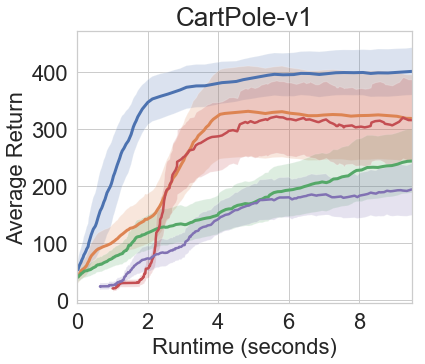

In [3]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

a2c_file_list = ['./log_files/a2c/CartPole-v1-1583988257.742302.csv', './log_files/a2c/CartPole-v1-1581924218.222175.csv',
                './log_files/a2c/CartPole-v1-1583951983.017687.csv','./log_files/a2c/CartPole-v1-1583953260.6407459.csv',
                './log_files/a2c/CartPole-v1-1583953298.755656.csv']
kl_file_list = ['./log_files/dr_trpo_kl/CartPole-v1-1581924483.4587069.csv', './log_files/dr_trpo_kl/CartPole-v1-1583890398.574406.csv',
               './log_files/dr_trpo_kl/CartPole-v1-1583952153.9513202.csv', './log_files/dr_trpo_kl/CartPole-v1-1583953051.3048809.csv',
               './log_files/dr_trpo_kl/CartPole-v1-1583952775.07668.csv']
wass_file_list = ['./log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv', './log_files/dr_trpo_wass/CartPole-v1-1585971521.2477708.csv',
                 './log_files/dr_trpo_wass/CartPole-v1-1586164922.54085.csv', './log_files/dr_trpo_wass/CartPole-v1-1581924172.541198.csv',
                 './log_files/dr_trpo_wass/CartPole-v1-1582186716.514488.csv']
window_size = 30
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Runtime (seconds)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,9.5)
plt.title('CartPole-v1', fontsize = 26)

# DRPO KL
x_val = pd.read_csv(kl_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(kl_file_list, window_size,0.5)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='DRPO-KL', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# DRPO Wass
x_val = pd.read_csv(wass_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(wass_file_list, window_size,0.5)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='DRPO-Wass', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# # A2C
x_val = pd.read_csv(a2c_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(a2c_file_list, window_size,0.5)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='A2C', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# read TRPO baseline results
trpo_log_name = ['./tmp/trpo_cartpole_monitor1.csv', './tmp/trpo_cartpole_monitor2.csv',
                 './tmp/trpo_cartpole_monitor3.csv', './tmp/trpo_cartpole_monitor4.csv',
                './tmp/trpo_cartpole_monitor5.csv']
x_val = pd.read_csv(trpo_log_name[1], sep=',', skiprows = 0, header= 1)['t']
window_size = 30
moving_average = find_baseline_moving_avg(trpo_log_name, window_size,0.5)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='TRPO', linewidth = 2.5)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)


# read PPO baseline results
ppo_log_name = ['./tmp/ppo_cartpole_monitor1.csv',
               './tmp/ppo_cartpole_monitor2.csv','./tmp/ppo_cartpole_monitor3.csv',
               './tmp/ppo_cartpole_monitor4.csv','./tmp/ppo_cartpole_monitor5.csv',]
window_size = 30
x_val = pd.read_csv(ppo_log_name[0], sep=',', skiprows = 0, header= 1)['t']
moving_average = find_baseline_moving_avg(ppo_log_name, window_size,0.5)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='PPO', linewidth = 2.5)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

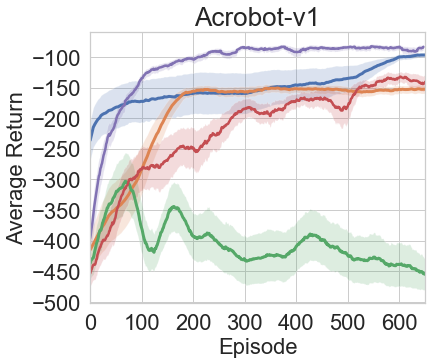

In [4]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

a2c_file_list = ['./log_files/a2c/Acrobot-v1-1583752961.230151.csv', './log_files/a2c/Acrobot-v1-1587115995.950804.csv',
                './log_files/a2c/Acrobot-v1-1587116209.9532642.csv', './log_files/a2c/Acrobot-v1-1587116492.970506.csv',
                './log_files/a2c/Acrobot-v1-1587116925.5854871.csv']
kl_file_list = ['./log_files/dr_trpo_kl/Acrobot-v1-1583751552.3857012.csv', './log_files/dr_trpo_kl/Acrobot-v1-1583970696.301418.csv',
               './log_files/dr_trpo_kl/Acrobot-v1-1586117014.473505.csv', './log_files/dr_trpo_kl/Acrobot-v1-1586131510.5272682.csv',
               './log_files/dr_trpo_kl/Acrobot-v1-1586140832.517568.csv']
wass_file_list = ['./log_files/dr_trpo_wass/Acrobot-v1-1583983141.8097558.csv', './log_files/dr_trpo_wass/Acrobot-v1-1586073086.365524.csv',
                 './log_files/dr_trpo_wass/Acrobot-v1-1586131507.532618.csv', './log_files/dr_trpo_wass/Acrobot-v1-1586140916.3434792.csv',
                 './log_files/dr_trpo_wass/Acrobot-v1-1586462541.3166761.csv']
window_size = 30
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Episode', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,650)
plt.title('Acrobot-v1', fontsize = 26)

# DRPO KL
eps_per_iter = 3
moving_average = find_drpo_moving_avg(kl_file_list, window_size,0.3)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='DRPO-KL', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)

# DRPO Wass
eps_per_iter = 3
moving_average = find_drpo_moving_avg(wass_file_list, window_size,0.3)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='DRPO-Wass', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)

# A2C
eps_per_iter = 1
moving_average = find_drpo_moving_avg(a2c_file_list, window_size,0.3)
ax.plot(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[0], label='A2C', linewidth = 3)
ax.fill_between(np.arange(len(moving_average[0]))*eps_per_iter, moving_average[1], moving_average[2], alpha=0.2)


# read TRPO baseline results
trpo_log_name = ['./tmp/trpo_acrobot_monitor1.csv', './tmp/trpo_acrobot_monitor2.csv', 
                 './tmp/trpo_acrobot_monitor3.csv', './tmp/trpo_acrobot_monitor4.csv',
                './tmp/trpo_acrobot_monitor5.csv']
window_size = 30
moving_average = find_baseline_moving_avg(trpo_log_name, window_size,0.3)
ax.plot(np.arange(len(moving_average[0])), moving_average[0], label='TRPO', linewidth = 2.5)
ax.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2)


# read PPO baseline results
ppo_log_name = ['./tmp/ppo_acrobot_monitor1.csv','./tmp/ppo_acrobot_monitor2.csv',
               './tmp/ppo_acrobot_monitor3.csv','./tmp/ppo_acrobot_monitor4.csv','./tmp/ppo_acrobot_monitor5.csv']
window_size = 30
moving_average = find_baseline_moving_avg(ppo_log_name, window_size,0.3)
ax.plot(np.arange(len(moving_average[0])), moving_average[0], label='PPO', linewidth = 2.5)
ax.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2)

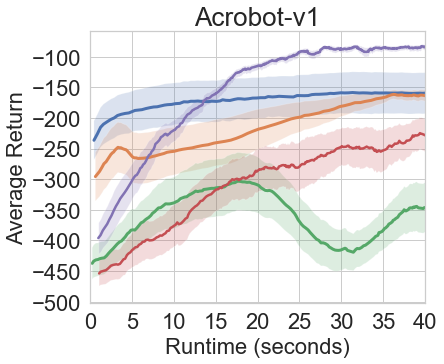

In [5]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

a2c_file_list = ['./log_files/a2c/Acrobot-v1-1583752961.230151.csv', './log_files/a2c/Acrobot-v1-1587115995.950804.csv',
                './log_files/a2c/Acrobot-v1-1587116209.9532642.csv', './log_files/a2c/Acrobot-v1-1587116492.970506.csv',
                './log_files/a2c/Acrobot-v1-1587116925.5854871.csv']
kl_file_list = ['./log_files/dr_trpo_kl/Acrobot-v1-1583751552.3857012.csv', './log_files/dr_trpo_kl/Acrobot-v1-1583970696.301418.csv',
               './log_files/dr_trpo_kl/Acrobot-v1-1586117014.473505.csv', './log_files/dr_trpo_kl/Acrobot-v1-1586131510.5272682.csv',
               './log_files/dr_trpo_kl/Acrobot-v1-1586140832.517568.csv']
wass_file_list = ['./log_files/dr_trpo_wass/Acrobot-v1-1583974481.819718.csv', './log_files/dr_trpo_wass/Acrobot-v1-1583979656.581634.csv',
                 './log_files/dr_trpo_wass/Acrobot-v1-1583983141.8097558.csv', './log_files/dr_trpo_wass/Acrobot-v1-1586140916.3434792.csv',
                 './log_files/dr_trpo_wass/Acrobot-v1-1586462541.3166761.csv']
window_size = 30
        
ax = plt.subplot(111)
plt.ylabel('Average Return', fontsize=22)
plt.xlabel('Runtime (seconds)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,40)
plt.title('Acrobot-v1', fontsize = 26)

# DRPO KL
x_val = pd.read_csv(kl_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(kl_file_list, window_size,0.3)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='DRPO-KL', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# DRPO Wass
x_val = pd.read_csv(wass_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(wass_file_list, window_size,0.3)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='DRPO-Wass', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# # A2C
x_val = pd.read_csv(a2c_file_list[0], sep=',', header= None)[0]
moving_average = find_drpo_moving_avg(a2c_file_list, window_size,0.3)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='A2C', linewidth = 3)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)

# read TRPO baseline results
trpo_log_name = ['./tmp/trpo_acrobot_monitor1.csv', './tmp/trpo_acrobot_monitor2.csv', 
                 './tmp/trpo_acrobot_monitor3.csv', './tmp/trpo_acrobot_monitor4.csv',
                './tmp/trpo_acrobot_monitor5.csv']
x_val = pd.read_csv(trpo_log_name[1], sep=',', skiprows = 0, header= 1)['t']
window_size = 30
moving_average = find_baseline_moving_avg(trpo_log_name, window_size,0.3)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='TRPO', linewidth = 2.5)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)


# read PPO baseline results
ppo_log_name = ['./tmp/ppo_acrobot_monitor1.csv','./tmp/ppo_acrobot_monitor2.csv',
               './tmp/ppo_acrobot_monitor3.csv','./tmp/ppo_acrobot_monitor4.csv','./tmp/ppo_acrobot_monitor5.csv']
window_size = 30
x_val = pd.read_csv(ppo_log_name[0], sep=',', skiprows = 0, header= 1)['t']
moving_average = find_baseline_moving_avg(ppo_log_name, window_size,0.3)
ax.plot(x_val[0:len(moving_average[0])], moving_average[0], label='PPO', linewidth = 2.5)
ax.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.2)